# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
rewards = [each[3] for each in batch]
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.0


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [7]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [9]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [10]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [17]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [18]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((57, 6), (57, 4), (57,), (57, 4), (57,), (57,), (57,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])
                if (np.max(rates)*0.9) > 0: # non-rated data -1
                    break
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.6535 dlossA:0.6604 dlossQ:1.1401 exploreP:0.9983
Episode:1 meanR:16.5000 R:16.0000 rate:0.0320 gloss:0.6711 dlossA:0.6642 dlossQ:1.1328 exploreP:0.9967
Episode:2 meanR:15.6667 R:14.0000 rate:0.0280 gloss:0.6499 dlossA:0.6571 dlossQ:1.1419 exploreP:0.9954
Episode:3 meanR:18.7500 R:28.0000 rate:0.0560 gloss:0.6525 dlossA:0.6554 dlossQ:1.1620 exploreP:0.9926
Episode:4 meanR:19.4000 R:22.0000 rate:0.0440 gloss:0.6468 dlossA:0.6450 dlossQ:1.1862 exploreP:0.9904
Episode:5 meanR:21.6667 R:33.0000 rate:0.0660 gloss:0.6434 dlossA:0.6493 dlossQ:1.1676 exploreP:0.9872
Episode:6 meanR:21.7143 R:22.0000 rate:0.0440 gloss:0.6520 dlossA:0.6557 dlossQ:1.1469 exploreP:0.9851
Episode:7 meanR:21.8750 R:23.0000 rate:0.0460 gloss:0.6587 dlossA:0.6607 dlossQ:1.1419 exploreP:0.9828
Episode:8 meanR:21.0000 R:14.0000 rate:0.0280 gloss:0.6555 dlossA:0.6606 dlossQ:1.1521 exploreP:0.9815
Episode:9 meanR:21.3000 R:24.0000 rate:0.0480 gloss:0.6484 dlossA:0.6491 

Episode:79 meanR:24.4250 R:24.0000 rate:0.0480 gloss:0.6485 dlossA:0.6586 dlossQ:1.1501 exploreP:0.8243
Episode:80 meanR:24.5432 R:34.0000 rate:0.0680 gloss:0.6504 dlossA:0.6618 dlossQ:1.1427 exploreP:0.8215
Episode:81 meanR:24.4024 R:13.0000 rate:0.0260 gloss:0.6499 dlossA:0.6575 dlossQ:1.1474 exploreP:0.8205
Episode:82 meanR:24.3012 R:16.0000 rate:0.0320 gloss:0.6397 dlossA:0.6515 dlossQ:1.1545 exploreP:0.8192
Episode:83 meanR:24.4167 R:34.0000 rate:0.0680 gloss:0.6417 dlossA:0.6484 dlossQ:1.1657 exploreP:0.8164
Episode:84 meanR:24.4000 R:23.0000 rate:0.0460 gloss:0.6588 dlossA:0.6624 dlossQ:1.1372 exploreP:0.8146
Episode:85 meanR:24.4302 R:27.0000 rate:0.0540 gloss:0.6412 dlossA:0.6610 dlossQ:1.1292 exploreP:0.8124
Episode:86 meanR:24.7356 R:51.0000 rate:0.1020 gloss:0.6487 dlossA:0.6596 dlossQ:1.1427 exploreP:0.8083
Episode:87 meanR:25.0909 R:56.0000 rate:0.1120 gloss:0.6424 dlossA:0.6483 dlossQ:1.1623 exploreP:0.8039
Episode:88 meanR:25.6067 R:71.0000 rate:0.1420 gloss:0.6395 dlos

Episode:158 meanR:44.0500 R:67.0000 rate:0.1340 gloss:0.6366 dlossA:0.6512 dlossQ:1.1522 exploreP:0.5623
Episode:159 meanR:44.5200 R:79.0000 rate:0.1580 gloss:0.6283 dlossA:0.6538 dlossQ:1.1299 exploreP:0.5580
Episode:160 meanR:44.8500 R:52.0000 rate:0.1040 gloss:0.6292 dlossA:0.6568 dlossQ:1.1091 exploreP:0.5551
Episode:161 meanR:44.8600 R:36.0000 rate:0.0720 gloss:0.6206 dlossA:0.6411 dlossQ:1.1495 exploreP:0.5532
Episode:162 meanR:45.2400 R:64.0000 rate:0.1280 gloss:0.6312 dlossA:0.6523 dlossQ:1.1370 exploreP:0.5497
Episode:163 meanR:45.8100 R:80.0000 rate:0.1600 gloss:0.6387 dlossA:0.6629 dlossQ:1.1075 exploreP:0.5454
Episode:164 meanR:46.1800 R:83.0000 rate:0.1660 gloss:0.6327 dlossA:0.6544 dlossQ:1.1236 exploreP:0.5410
Episode:165 meanR:46.4900 R:42.0000 rate:0.0840 gloss:0.6322 dlossA:0.6535 dlossQ:1.1275 exploreP:0.5387
Episode:166 meanR:46.5600 R:45.0000 rate:0.0900 gloss:0.6256 dlossA:0.6430 dlossQ:1.1342 exploreP:0.5364
Episode:167 meanR:46.6900 R:32.0000 rate:0.0640 gloss:0

Episode:236 meanR:80.8900 R:74.0000 rate:0.1480 gloss:0.5859 dlossA:0.6442 dlossQ:1.0943 exploreP:0.2947
Episode:237 meanR:80.6100 R:30.0000 rate:0.0600 gloss:0.5749 dlossA:0.6398 dlossQ:1.1556 exploreP:0.2939
Episode:238 meanR:80.7900 R:114.0000 rate:0.2280 gloss:0.6081 dlossA:0.6545 dlossQ:1.0727 exploreP:0.2907
Episode:239 meanR:81.1700 R:74.0000 rate:0.1480 gloss:0.6074 dlossA:0.6520 dlossQ:1.0713 exploreP:0.2886
Episode:240 meanR:81.4300 R:73.0000 rate:0.1460 gloss:0.5986 dlossA:0.6461 dlossQ:1.0952 exploreP:0.2866
Episode:241 meanR:81.1500 R:107.0000 rate:0.2140 gloss:0.6042 dlossA:0.6519 dlossQ:1.0882 exploreP:0.2836
Episode:242 meanR:80.7400 R:72.0000 rate:0.1440 gloss:0.6045 dlossA:0.6534 dlossQ:1.0690 exploreP:0.2817
Episode:243 meanR:81.1300 R:57.0000 rate:0.1140 gloss:0.5933 dlossA:0.6448 dlossQ:1.0926 exploreP:0.2801
Episode:244 meanR:82.5300 R:197.0000 rate:0.3940 gloss:0.5898 dlossA:0.6451 dlossQ:1.0823 exploreP:0.2749
Episode:245 meanR:83.5900 R:172.0000 rate:0.3440 glo

Episode:314 meanR:87.5100 R:70.0000 rate:0.1400 gloss:0.5758 dlossA:0.6611 dlossQ:1.0304 exploreP:0.1587
Episode:315 meanR:87.2000 R:84.0000 rate:0.1680 gloss:0.5982 dlossA:0.6537 dlossQ:1.1130 exploreP:0.1574
Episode:316 meanR:86.7100 R:54.0000 rate:0.1080 gloss:0.5794 dlossA:0.6592 dlossQ:1.0323 exploreP:0.1566
Episode:317 meanR:87.4200 R:118.0000 rate:0.2360 gloss:0.5829 dlossA:0.6523 dlossQ:1.0831 exploreP:0.1549
Episode:318 meanR:87.4000 R:56.0000 rate:0.1120 gloss:0.5710 dlossA:0.6550 dlossQ:1.0443 exploreP:0.1541
Episode:319 meanR:87.2600 R:76.0000 rate:0.1520 gloss:0.5685 dlossA:0.6452 dlossQ:1.0699 exploreP:0.1530
Episode:320 meanR:87.1200 R:104.0000 rate:0.2080 gloss:0.5501 dlossA:0.6407 dlossQ:1.0744 exploreP:0.1515
Episode:321 meanR:86.9600 R:76.0000 rate:0.1520 gloss:0.5869 dlossA:0.6598 dlossQ:1.0355 exploreP:0.1505
Episode:322 meanR:86.0800 R:54.0000 rate:0.1080 gloss:0.5664 dlossA:0.6533 dlossQ:1.0530 exploreP:0.1497
Episode:323 meanR:86.1300 R:81.0000 rate:0.1620 gloss

Episode:392 meanR:79.8800 R:60.0000 rate:0.1200 gloss:0.4836 dlossA:0.6333 dlossQ:1.0978 exploreP:0.0909
Episode:393 meanR:79.8400 R:51.0000 rate:0.1020 gloss:0.5195 dlossA:0.6492 dlossQ:1.0554 exploreP:0.0905
Episode:394 meanR:79.9100 R:96.0000 rate:0.1920 gloss:0.5518 dlossA:0.6560 dlossQ:1.0635 exploreP:0.0897
Episode:395 meanR:79.7400 R:61.0000 rate:0.1220 gloss:0.5459 dlossA:0.6575 dlossQ:1.0379 exploreP:0.0893
Episode:396 meanR:79.1700 R:66.0000 rate:0.1320 gloss:0.5481 dlossA:0.6467 dlossQ:1.0523 exploreP:0.0887
Episode:397 meanR:78.9100 R:52.0000 rate:0.1040 gloss:0.5146 dlossA:0.6411 dlossQ:1.0497 exploreP:0.0883
Episode:398 meanR:79.1200 R:48.0000 rate:0.0960 gloss:0.5457 dlossA:0.6544 dlossQ:1.0563 exploreP:0.0880
Episode:399 meanR:79.1700 R:73.0000 rate:0.1460 gloss:0.5218 dlossA:0.6496 dlossQ:1.0626 exploreP:0.0874
Episode:400 meanR:78.5800 R:39.0000 rate:0.0780 gloss:0.5254 dlossA:0.6469 dlossQ:1.0312 exploreP:0.0871
Episode:401 meanR:77.3700 R:54.0000 rate:0.1080 gloss:0

Episode:470 meanR:72.9700 R:131.0000 rate:0.2620 gloss:0.4303 dlossA:0.6258 dlossQ:1.3416 exploreP:0.0563
Episode:471 meanR:72.9100 R:53.0000 rate:0.1060 gloss:0.4592 dlossA:0.6416 dlossQ:1.1105 exploreP:0.0560
Episode:472 meanR:73.4500 R:101.0000 rate:0.2020 gloss:0.4518 dlossA:0.6422 dlossQ:1.1624 exploreP:0.0556
Episode:473 meanR:73.2000 R:51.0000 rate:0.1020 gloss:0.4900 dlossA:0.6447 dlossQ:1.0888 exploreP:0.0553
Episode:474 meanR:73.0000 R:87.0000 rate:0.1740 gloss:0.4462 dlossA:0.6412 dlossQ:1.1474 exploreP:0.0550
Episode:475 meanR:72.7700 R:76.0000 rate:0.1520 gloss:0.4452 dlossA:0.6274 dlossQ:1.2663 exploreP:0.0546
Episode:476 meanR:72.6600 R:42.0000 rate:0.0840 gloss:0.4924 dlossA:0.6493 dlossQ:1.1142 exploreP:0.0544
Episode:477 meanR:72.6400 R:69.0000 rate:0.1380 gloss:0.4791 dlossA:0.6425 dlossQ:1.1248 exploreP:0.0541
Episode:478 meanR:72.1500 R:55.0000 rate:0.1100 gloss:0.4112 dlossA:0.6271 dlossQ:1.1531 exploreP:0.0539
Episode:479 meanR:71.5500 R:49.0000 rate:0.0980 gloss

Episode:548 meanR:66.3300 R:67.0000 rate:0.1340 gloss:0.4449 dlossA:0.6261 dlossQ:1.2632 exploreP:0.0376
Episode:549 meanR:66.3300 R:58.0000 rate:0.1160 gloss:0.3748 dlossA:0.6141 dlossQ:1.3463 exploreP:0.0374
Episode:550 meanR:66.4500 R:66.0000 rate:0.1320 gloss:0.3073 dlossA:0.6420 dlossQ:1.5765 exploreP:0.0372
Episode:551 meanR:66.7700 R:86.0000 rate:0.1720 gloss:0.3340 dlossA:0.6085 dlossQ:1.3754 exploreP:0.0370
Episode:552 meanR:66.5200 R:73.0000 rate:0.1460 gloss:0.4291 dlossA:0.6371 dlossQ:1.2681 exploreP:0.0368
Episode:553 meanR:66.1000 R:50.0000 rate:0.1000 gloss:0.4341 dlossA:0.6323 dlossQ:1.3441 exploreP:0.0367
Episode:554 meanR:65.9500 R:56.0000 rate:0.1120 gloss:0.3854 dlossA:0.6173 dlossQ:1.3439 exploreP:0.0365
Episode:555 meanR:66.6100 R:119.0000 rate:0.2380 gloss:0.3635 dlossA:0.6281 dlossQ:1.3627 exploreP:0.0362
Episode:556 meanR:66.4200 R:56.0000 rate:0.1120 gloss:0.4055 dlossA:0.6134 dlossQ:1.2913 exploreP:0.0361
Episode:557 meanR:66.7000 R:72.0000 rate:0.1440 gloss:

Episode:626 meanR:69.4900 R:52.0000 rate:0.1040 gloss:0.1363 dlossA:0.5857 dlossQ:1.6195 exploreP:0.0261
Episode:627 meanR:69.5500 R:56.0000 rate:0.1120 gloss:0.3347 dlossA:0.6157 dlossQ:1.4594 exploreP:0.0260
Episode:628 meanR:69.5700 R:55.0000 rate:0.1100 gloss:-0.0890 dlossA:0.6019 dlossQ:1.8861 exploreP:0.0259
Episode:629 meanR:69.1900 R:58.0000 rate:0.1160 gloss:0.3239 dlossA:0.6017 dlossQ:1.5103 exploreP:0.0258
Episode:630 meanR:69.0300 R:47.0000 rate:0.0940 gloss:-0.0301 dlossA:0.5958 dlossQ:1.9971 exploreP:0.0257
Episode:631 meanR:69.0300 R:58.0000 rate:0.1160 gloss:0.3403 dlossA:0.5959 dlossQ:1.4929 exploreP:0.0256
Episode:632 meanR:68.8400 R:58.0000 rate:0.1160 gloss:0.2616 dlossA:0.5880 dlossQ:1.6190 exploreP:0.0256
Episode:633 meanR:69.4100 R:94.0000 rate:0.1880 gloss:0.3167 dlossA:0.5939 dlossQ:1.6051 exploreP:0.0254
Episode:634 meanR:69.4700 R:72.0000 rate:0.1440 gloss:0.2718 dlossA:0.5882 dlossQ:1.5266 exploreP:0.0253
Episode:635 meanR:69.7500 R:80.0000 rate:0.1600 gloss

Episode:704 meanR:75.7800 R:40.0000 rate:0.0800 gloss:0.2811 dlossA:0.6012 dlossQ:1.4908 exploreP:0.0189
Episode:705 meanR:75.7500 R:51.0000 rate:0.1020 gloss:0.2570 dlossA:0.5943 dlossQ:1.5641 exploreP:0.0188
Episode:706 meanR:75.4900 R:62.0000 rate:0.1240 gloss:0.2010 dlossA:0.5678 dlossQ:1.6491 exploreP:0.0188
Episode:707 meanR:74.2400 R:44.0000 rate:0.0880 gloss:0.0941 dlossA:0.5752 dlossQ:1.6378 exploreP:0.0187
Episode:708 meanR:73.8900 R:49.0000 rate:0.0980 gloss:0.3759 dlossA:0.5621 dlossQ:2.0459 exploreP:0.0187
Episode:709 meanR:73.9700 R:84.0000 rate:0.1680 gloss:0.2040 dlossA:0.5731 dlossQ:1.6286 exploreP:0.0186
Episode:710 meanR:74.0400 R:68.0000 rate:0.1360 gloss:0.2511 dlossA:0.5766 dlossQ:1.6497 exploreP:0.0186
Episode:711 meanR:73.4000 R:44.0000 rate:0.0880 gloss:0.1335 dlossA:0.5650 dlossQ:1.7584 exploreP:0.0185
Episode:712 meanR:73.6500 R:76.0000 rate:0.1520 gloss:0.1895 dlossA:0.5781 dlossQ:1.7459 exploreP:0.0185
Episode:713 meanR:73.8400 R:58.0000 rate:0.1160 gloss:0

Episode:782 meanR:68.7400 R:90.0000 rate:0.1800 gloss:-1.1190 dlossA:0.5246 dlossQ:1.9664 exploreP:0.0153
Episode:783 meanR:68.4100 R:35.0000 rate:0.0700 gloss:-0.3568 dlossA:0.5251 dlossQ:1.6765 exploreP:0.0153
Episode:784 meanR:67.8800 R:43.0000 rate:0.0860 gloss:-0.4063 dlossA:0.5023 dlossQ:1.7445 exploreP:0.0152
Episode:785 meanR:67.8400 R:46.0000 rate:0.0920 gloss:-0.1705 dlossA:0.5147 dlossQ:2.0939 exploreP:0.0152
Episode:786 meanR:67.5800 R:66.0000 rate:0.1320 gloss:-0.4237 dlossA:0.5575 dlossQ:1.6090 exploreP:0.0152
Episode:787 meanR:67.5700 R:110.0000 rate:0.2200 gloss:-0.4703 dlossA:0.5363 dlossQ:1.6055 exploreP:0.0151
Episode:788 meanR:67.4600 R:49.0000 rate:0.0980 gloss:-0.3124 dlossA:0.5179 dlossQ:1.6315 exploreP:0.0151
Episode:789 meanR:67.3000 R:43.0000 rate:0.0860 gloss:-0.4097 dlossA:0.5260 dlossQ:1.5937 exploreP:0.0151
Episode:790 meanR:67.1700 R:39.0000 rate:0.0780 gloss:-0.5445 dlossA:0.5127 dlossQ:1.6290 exploreP:0.0151
Episode:791 meanR:66.7600 R:37.0000 rate:0.07

Episode:860 meanR:64.1500 R:37.0000 rate:0.0740 gloss:-2.2882 dlossA:0.5076 dlossQ:1.9022 exploreP:0.0132
Episode:861 meanR:64.1700 R:41.0000 rate:0.0820 gloss:-0.7015 dlossA:0.5530 dlossQ:1.5986 exploreP:0.0132
Episode:862 meanR:64.2200 R:50.0000 rate:0.1000 gloss:-2.3799 dlossA:0.5084 dlossQ:1.9394 exploreP:0.0132
Episode:863 meanR:64.8000 R:96.0000 rate:0.1920 gloss:-0.6269 dlossA:0.5354 dlossQ:1.6570 exploreP:0.0131
Episode:864 meanR:64.5700 R:35.0000 rate:0.0700 gloss:-0.5093 dlossA:0.5407 dlossQ:1.6251 exploreP:0.0131
Episode:865 meanR:64.8200 R:82.0000 rate:0.1640 gloss:-1.8053 dlossA:0.5230 dlossQ:1.8385 exploreP:0.0131
Episode:866 meanR:64.7400 R:54.0000 rate:0.1080 gloss:-1.3615 dlossA:0.5188 dlossQ:1.7543 exploreP:0.0131
Episode:867 meanR:64.2500 R:41.0000 rate:0.0820 gloss:-0.9096 dlossA:0.5374 dlossQ:1.6962 exploreP:0.0131
Episode:868 meanR:63.7800 R:61.0000 rate:0.1220 gloss:-1.4659 dlossA:0.5602 dlossQ:1.7058 exploreP:0.0131
Episode:869 meanR:63.8800 R:43.0000 rate:0.086

Episode:938 meanR:62.1200 R:40.0000 rate:0.0800 gloss:-0.4953 dlossA:0.5470 dlossQ:1.5728 exploreP:0.0120
Episode:939 meanR:61.9100 R:36.0000 rate:0.0720 gloss:-2.8646 dlossA:0.5356 dlossQ:1.6966 exploreP:0.0120
Episode:940 meanR:62.9400 R:142.0000 rate:0.2840 gloss:-1.8140 dlossA:0.5649 dlossQ:1.7095 exploreP:0.0119
Episode:941 meanR:62.9000 R:37.0000 rate:0.0740 gloss:-1.2349 dlossA:0.5444 dlossQ:1.6728 exploreP:0.0119
Episode:942 meanR:63.1500 R:71.0000 rate:0.1420 gloss:-1.2732 dlossA:0.5620 dlossQ:1.9068 exploreP:0.0119
Episode:943 meanR:63.2900 R:51.0000 rate:0.1020 gloss:-1.1805 dlossA:0.5603 dlossQ:1.7486 exploreP:0.0119
Episode:944 meanR:62.8200 R:78.0000 rate:0.1560 gloss:0.0988 dlossA:0.5963 dlossQ:1.5372 exploreP:0.0119
Episode:945 meanR:63.2200 R:90.0000 rate:0.1800 gloss:-0.6314 dlossA:0.5563 dlossQ:1.6892 exploreP:0.0119
Episode:946 meanR:63.2000 R:60.0000 rate:0.1200 gloss:-1.2881 dlossA:0.5544 dlossQ:1.6547 exploreP:0.0119
Episode:947 meanR:62.8000 R:39.0000 rate:0.078

Episode:1016 meanR:62.9800 R:50.0000 rate:0.1000 gloss:-3.6717 dlossA:0.6144 dlossQ:1.9192 exploreP:0.0112
Episode:1017 meanR:62.9800 R:46.0000 rate:0.0920 gloss:-2.3883 dlossA:0.6082 dlossQ:1.7228 exploreP:0.0112
Episode:1018 meanR:62.9700 R:62.0000 rate:0.1240 gloss:-2.3345 dlossA:0.5705 dlossQ:1.8806 exploreP:0.0112
Episode:1019 meanR:62.9500 R:60.0000 rate:0.1200 gloss:-4.2097 dlossA:0.5703 dlossQ:1.9692 exploreP:0.0112
Episode:1020 meanR:63.0600 R:58.0000 rate:0.1160 gloss:-2.1343 dlossA:0.5873 dlossQ:1.7890 exploreP:0.0112
Episode:1021 meanR:63.6600 R:104.0000 rate:0.2080 gloss:-3.7115 dlossA:0.5810 dlossQ:1.8532 exploreP:0.0112
Episode:1022 meanR:64.0100 R:71.0000 rate:0.1420 gloss:-2.7202 dlossA:0.5792 dlossQ:1.7558 exploreP:0.0112
Episode:1023 meanR:63.7800 R:42.0000 rate:0.0840 gloss:-6.7647 dlossA:0.5753 dlossQ:2.2080 exploreP:0.0112
Episode:1024 meanR:64.1900 R:85.0000 rate:0.1700 gloss:-7.0824 dlossA:0.5778 dlossQ:2.0195 exploreP:0.0111
Episode:1025 meanR:64.5800 R:80.0000

Episode:1093 meanR:64.4400 R:45.0000 rate:0.0900 gloss:-5.6595 dlossA:0.6170 dlossQ:2.1605 exploreP:0.0107
Episode:1094 meanR:64.5600 R:60.0000 rate:0.1200 gloss:-8.6087 dlossA:0.5923 dlossQ:2.6076 exploreP:0.0107
Episode:1095 meanR:64.7800 R:57.0000 rate:0.1140 gloss:-4.1019 dlossA:0.6064 dlossQ:2.2169 exploreP:0.0107
Episode:1096 meanR:64.7600 R:41.0000 rate:0.0820 gloss:-1.9271 dlossA:0.5902 dlossQ:2.0620 exploreP:0.0107
Episode:1097 meanR:64.8600 R:57.0000 rate:0.1140 gloss:-8.1086 dlossA:0.5686 dlossQ:2.3066 exploreP:0.0107
Episode:1098 meanR:65.1700 R:72.0000 rate:0.1440 gloss:-8.6695 dlossA:0.5759 dlossQ:2.4814 exploreP:0.0107
Episode:1099 meanR:65.2900 R:70.0000 rate:0.1400 gloss:-9.9732 dlossA:0.5851 dlossQ:2.5883 exploreP:0.0107
Episode:1100 meanR:65.1300 R:46.0000 rate:0.0920 gloss:-9.9310 dlossA:0.5622 dlossQ:2.4723 exploreP:0.0107
Episode:1101 meanR:65.1300 R:58.0000 rate:0.1160 gloss:-7.6074 dlossA:0.5887 dlossQ:2.4186 exploreP:0.0107
Episode:1102 meanR:65.0200 R:70.0000 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

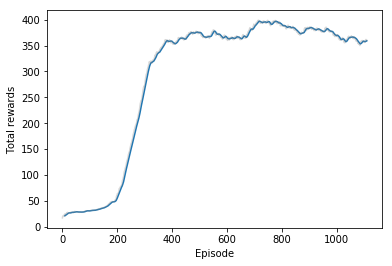

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

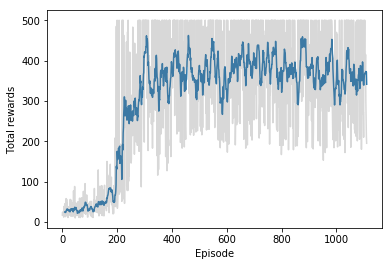

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [64]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-64-a0b0af09d9f3>, line 6)

In [ ]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.